# Baseline network

This notebook trains the baseline network with exact same architecture as the one in paper [Recognition of handwritten Latin characters with diacritics using CNN](https://journals.pan.pl/dlibra/publication/136210/edition/119099/content/bulletin-of-the-polish-academy-of-sciences-technical-sciences-recognition-of-handwritten-latin-characters-with-diacritics-using-cnn-lukasik-edyta-charytanowicz-malgorzata-milosz-marek-tokovarov-michail-kaczorowska-monika-czerwinski-dariusz-zientarski-tomasz-2021-69-no-1?language=en)

Model architecture description:

- Input layer (32x32 grayscale image) 

- feature extraction
    - Conv2d (padding = 1, kernel = (3,3), stride = 1, activation = relu) 
    - MaxPool layer ( kernel=(2,2), stride=2) 
    - Conv2d layer (padding = 1, kernel = (3,3), stride = 1, activation = relu) 
    - MaxPool layer ( kernel=(2,2), stride=2) 

- dense layers
    - Dense(5376)
    - Dense(256)
    - Dense( number of classes - here in paper 89 classes)




After training, model is serialized and uploaded to W&B project.

In [2]:
import wandb
import tensorflow as tf
import numpy as np
import pathlib
import shutil

def load_data( run = wandb.init(project="master-thesis", job_type="preprocessing")) -> pathlib.Path:
    """
    Unpacks data from an artifact into a folder and returns the path to the folder.
    """

    artifact_name = f"letters_splits"
    artifact = run.use_artifact(f"master-thesis/{artifact_name}:latest")
    artifact_dir = artifact.download()
    artifact_dir = pathlib.Path(artifact_dir).resolve()
    
    for split_file in artifact_dir.iterdir():
        if split_file.name.endswith(".tar.gz"):
            split = split_file.name.replace(".tar.gz", "")
            shutil.unpack_archive(split_file, artifact_dir / split, format="gztar")
    return [ artifact_dir / split for split in ["train", "test", "val"]]

def get_number_of_classes(ds: tf.data.Dataset) -> int:
    """
    Returns the number of classes in a dataset.
    """
    return len(ds.class_names)

def create_tf_dataset(split_path: pathlib.Path, batch_size: int = 32):
    """
    Creates a tf dataset from path containing a folder for each class.
    """
    ds = tf.keras.utils.image_dataset_from_directory(
        split_path, 
        image_size=(32,32), 
        batch_size=batch_size,
        color_mode='grayscale',
    )
    return ds

def preprocess_dataset(ds: tf.data.Dataset) -> tf.data.Dataset :
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)) # normalize
    return ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gratkadlafana. Use `wandb login --relogin` to force relogin


In [3]:
MODEL_NAME = "baseline-phcd"
run = wandb.init(project="master-thesis", job_type="training", name=MODEL_NAME)
split_paths = load_data(run=run)

wandb:   3 of 3 files downloaded.  


In [4]:
BATCH_SIZE = 32
ds_train, ds_test, ds_val = [
    create_tf_dataset(split_path, batch_size=BATCH_SIZE) for split_path in split_paths
    ]

num_classes = len(ds_train.class_names)

print(f"There are {num_classes} classes")
print(f"Training set has {len(ds_train)} batches")
print(f"Test set has {len(ds_test)} batches")
print(f"Validation set has {len(ds_val)} batches")

Found 176116 files belonging to 35 classes.
Found 22001 files belonging to 35 classes.
Found 22001 files belonging to 35 classes.
There are 35 classes
Training set has 5504 batches
Test set has 688 batches
Validation set has 688 batches


In [5]:
ds_train = preprocess_dataset(ds_train)
ds_val = preprocess_dataset(ds_val)
ds_test = preprocess_dataset(ds_test)

model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(32, 32, 1)),
        tf.keras.layers.Conv2D(32,kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(5376, activation="relu"),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
    callbacks=[wandb.keras.WandbCallback()],
)

history = model.fit(
    ds_train,
    epochs=100,
    validation_data=ds_val,
)

c:\Users\Wiktor\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5504/5504 [==============================] - 126s 23ms/step - loss: 0.4379 - accuracy: 0.8686 - val_loss: 0.2603 - val_accuracy: 0.9204


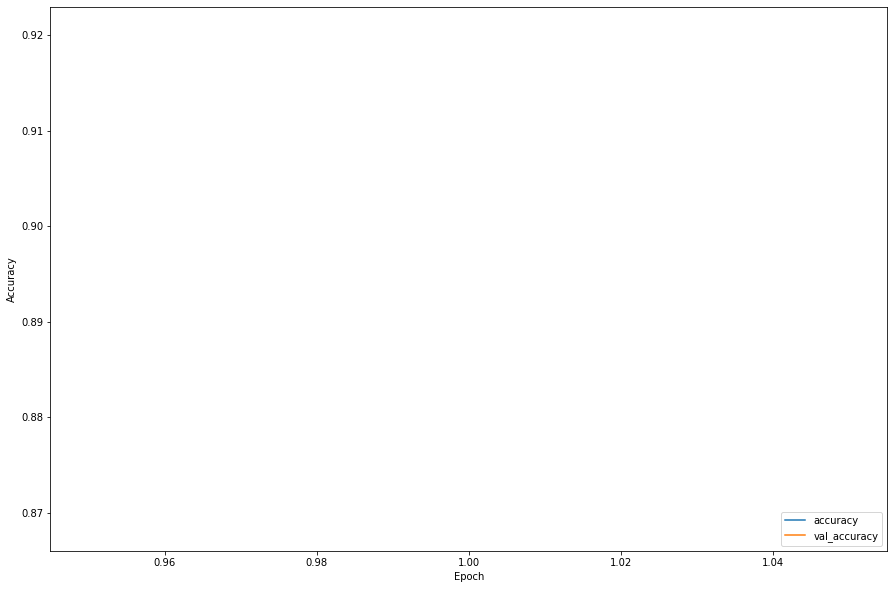

In [6]:
# plot history
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
epochs = range(1, len(history.history["loss"]) + 1)
ax.plot(epochs, history.history["accuracy"], label="accuracy")
ax.plot(epochs, history.history["val_accuracy"], label="val_accuracy")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend(loc="lower right")

plt.show()

In [9]:
# evaluate model on ds_test and log to wandb

test_loss, test_acc = model.evaluate(ds_test)

wandb.log({"test_loss": test_loss, "test_acc": test_acc})

# create an artifact
artifact = wandb.Artifact(
    name=MODEL_NAME,
    type="model"
)

# save model to artifact
model.save(f"./artifacts/{MODEL_NAME}.h5")
artifact.add_file(f"./artifacts/{MODEL_NAME}.h5")
run.log_artifact(artifact)
run.finish()

688/688 [==============================] - 2s 4ms/step - loss: 0.2603 - accuracy: 0.9204


test_acc,▁▁▁
test_loss,▁▁▁
test_acc,0.92037
test_loss,0.26031
